# Gravitation constrained to a surface

Consider a point mass $m$ constrained to a surface in the 3-D space. The system is submitted to a uniform constant gravitation $g$ and moves without friction. For simplicity, we assume that the surface is stable by rotation around an axis $\Delta$ parallel to $g$. The referential is taken to be centred on a point $O$ of $\Delta$. Its $z$-axis is taken to be the semi-axis of $\Delta$ in the opposite direction to $g$. The $x$- and $y$-axes are chosen arbitrarily so as to form an orthogonal basis.

The generalised coordinates of the system are the angle $\phi$ ("azimuth") which is the polar coordinate of the projection of the point mass on the $x,y$-plane, and the angle $\theta$ ("zenith") which is the angle of the $z$-axis with the point mass. We have $0\leq\theta\leq\pi$, and any two $\theta,\phi$ identify a single point on the surface at radius $R(\theta)$. The coordinates of the point mass are then given by


\begin{equation*}
x = R\sin\theta\cos\phi
\hspace{2cm}
y = R\sin\theta\sin\phi
\hspace{2cm}
z = -R\cos\theta
\end{equation*}

The only active force is weight with coordinates $(0,0,-mg)$, hence of the form $-\nabla V$ with $V=mgz=-mgR\cos\theta$. Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & m\left(\frac{1}{2}R^2\dot{\phi}^2\sin^2\theta+\frac{1}{2}(R^2+R'^2)\dot{\theta}^2+gR\cos\theta\right)
\end{eqnarray*}

Introducing the intermediary variable $\lambda=R^2\dot{\phi}\sin^2\theta$ (angular momentum), the equations of the dynamics are given by:

\begin{align*}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\phi}} = \frac{\partial\mathcal{L}}{\partial\phi}\right]
\hspace{1cm} &
\lambda=R^2\dot{\phi}\sin^2\theta
\hspace{1cm}
\dot{\lambda} = 0
\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\ddot{\theta} = \frac{1}{R^2+R'^2}\left(\frac{\lambda^2}{R^3\sin^3\theta}(R'\sin\theta+R\cos\theta)+g(R'\cos\theta-R\sin\theta)-R'(R+R'')\dot{\theta}^2\right)
\end{align*}

For a sphere, $R$ is independant of $\theta$ hence $R'=R''=0$ and, introducing $\Lambda\triangleq\frac{\lambda}{R^2}$, the system simplifies to

\begin{equation*}
\begin{array}{rcl}
\dot{\phi} & = & \frac{\Lambda}{\sin^2\theta}\\
\dot{\Lambda} & = & 0\\
\ddot{\theta} & = & \frac{\Lambda^2\cos\theta}{\sin^3\theta}-\frac{g}{R}\sin\theta
\end{array}
\end{equation*}

In [1]:
import logging; logging.basicConfig(level=logging.WARNING); logging.captureWarnings(True)
from numpy import sin,cos,pi,square,sqrt,array,linspace,radians
from ipyshow.odesimu import System

In [5]:
#----------------------------------------------------------------------------------------------------
class SphereSlider (System):
#----------------------------------------------------------------------------------------------------

  def __init__(self,R,G):
    r"""
Args:
  R (float): radius of the constraining sphere [m]
  G (float): intensity of the gravity [m.sec^-2]
    """
    self.R, self.G = R, G
    def fun(t,state,a=G/R):
      θ,θʹ,φ,Λ = state
      cosθ,sinθ = cos(θ),sin(θ)
      φʹ = Λ/square(sinθ)
      θʺ = (square(φʹ)*cosθ-a)*sinθ
      Λʹ = 0
      return array((θʹ,θʺ,φʹ,Λʹ))
    self.fun = fun
    def jac(t,state,a=G/R):
      θ,θʹ,φ,Λ = state
      cosθ,sinθ = cos(θ),sin(θ)
      s = 1/square(sinθ)
      v = 2*Λ*s*cosθ/sinθ
      return array(((0,1,0,0),(square(Λ)*s*(2-3*s)-a*cosθ,0,0,v),(-v,0,0,s),(0,0,0,0)))
    self.jac = jac
    def cartesian(state):
      θ,θʹ,φ,Λ = state
      r = R*sin(θ)
      return r*cos(φ),r*sin(φ),-R*cos(θ)
    self.cartesian = cartesian

  def displayer(self,env,ax,refsize=50.):
    r"""
Args:
  refsize (int): size (area) of the blob for display [pt^2]
    """
    from matplotlib.patches import Circle
    from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d
    R = self.R; R_ = 1.05*R
    ax.set(xlim=(-R_,R_),ylim=(-R_,R_),zlim=(-R_,R_))
    ax.set_title('trajectory:?',fontsize='x-small')
    ax.scatter((0.,),(0.,),(0.,),c='k',marker='o',s=refsize)
    pathpatch_2d_to_3d(ax.add_patch(Circle((0,0),R,ec='k',fc='none')),z=0)
    v = linspace(-pi,pi,100)
    xyv,zv = sin(v),-R*cos(v)
    a_mass = ax.scatter((),(),(),s=refsize,marker='o',c='r')
    a_base, = ax.plot((R,-R),(0.,0.),(0.,0.),'gray',ls=':')
    a_meridian, = ax.plot(xyv,xyv*0.,zv,'gray',ls=':')
    a_tail, = ax.plot((),(),(),'y')
    def disp():
      a_mass._offsets3d = self.cartesian(env.state[:,None])
      u = env.state[2]
      x,y = R*cos(u),R*sin(u)
      a_base.set_data_3d((x,-x),(y,-y),(0.,0.))
      a_meridian.set_data_3d(xyv*x,xyv*y,zv)
      a_tail.set_data_3d(*self.cartesian(env.cached_states))
    return disp

  @staticmethod
  def makestate(θ,θʹ=0.,φ=0.,φʹ=0.):
    r"""
Args:
  θ (float): zenith [deg]
  θʹ (float): angular speed (zenith) [deg.sec^-1]
  φ (float): azimuth [deg]
  φʹ (float): angular speed (azimuth) [deg.sec^-1]
    """
    s = square(sin(radians(θ)))
    return radians((θ,θʹ,φ,φʹ*s))

  launch_defaults = {'period':10.,'cache_spec':(10,.05),'max_step':.05}

In [6]:
%matplotlib widget
#%matplotlib qt6
from myutil.simpy import SimpySimulation

IPYControlledAnimation(children=(VBox(children=(HBox(children=(SimpleButton(icon='close', layout=Layout(paddin…

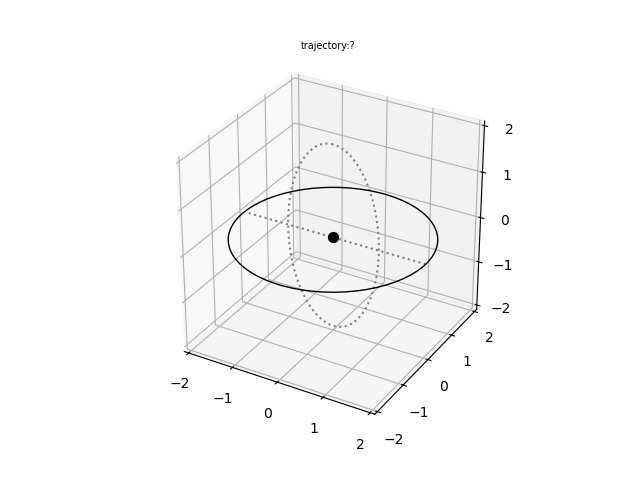

In [7]:
syst = SphereSlider(R=2.,G=9.81)
ini = dict(θ=135,θʹ=0,φʹ=-30)
#ini = dict(θ=75,θʹ=0,φʹ=-30)

SimpySimulation(
  syst.launch(init_y=ini),
  frame_per_stu=25,track=60.,
  panes_kw={'projection':'3d'}
)